## Important

`run_mafft.sh` and `run_raxml.sh` in each subfoloder of `Trees` to build the trees beforehand.

In [1]:
library(ape)
library(sitePath)
library(tibble)
library(ggplot2)
library(ggrepel)
library(RColorBrewer)
library(aplot)
suppressPackageStartupMessages(library(treeio))
suppressPackageStartupMessages(library(ggtree))

METADATA_DIR <- "Metadata"
TREES_DIR <- "Trees"
PLOTS_DIR <- "Plots"

H1N1_HA_NAME <- "H1N1_HA"
H3N2_HA_NAME <- "H3N2_HA"
H3N2_HA1_PRE2010_NAME <- "H3N2_HA1_pre2003"
ZIKV_POLYPROTEIN_NAME <- "ZIKV_polyprotein"
SARS_COV_2_CDS_NAME <- "SARS_CoV_2_cds"

H3N2_HA1_PRE2010_TREE_DIR <- file.path(TREES_DIR, H3N2_HA1_PRE2010_NAME)

dir.create(PLOTS_DIR, showWarnings = FALSE)

### 1. H3N2 HA1 pre2010

In [2]:
clusterSites <- c(
    122, 155, 207, 144, 188,
    137, 164, 53, 174, 145, 189, 278, 102, 193, 213, 217, 230,
    137, 158, 50, 174, 82, 164, 53, 201, 260, 193, 213, 230,
    133, 156, 53, 172, 143, 160, 54, 217, 82, 146, 197, 244,
    124, 155, 189,
    145,
    133, 156, 262, 145, 190,
    145,
    156, 276, 62, 158, 196,
    131, 155, 50, 75, 25, 156, 83, 202, 222, 225
)
clusterSites <- unique(clusterSites)

In [3]:
treeDir <- file.path(TREES_DIR, H3N2_HA1_PRE2010_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

In [4]:
clusterInfo <- read.csv(file.path(METADATA_DIR, paste0(H3N2_HA1_PRE2010_NAME, ".csv")), stringsAsFactors = FALSE)

In [5]:
paths <- lineagePath(tree, similarity = 0.07)

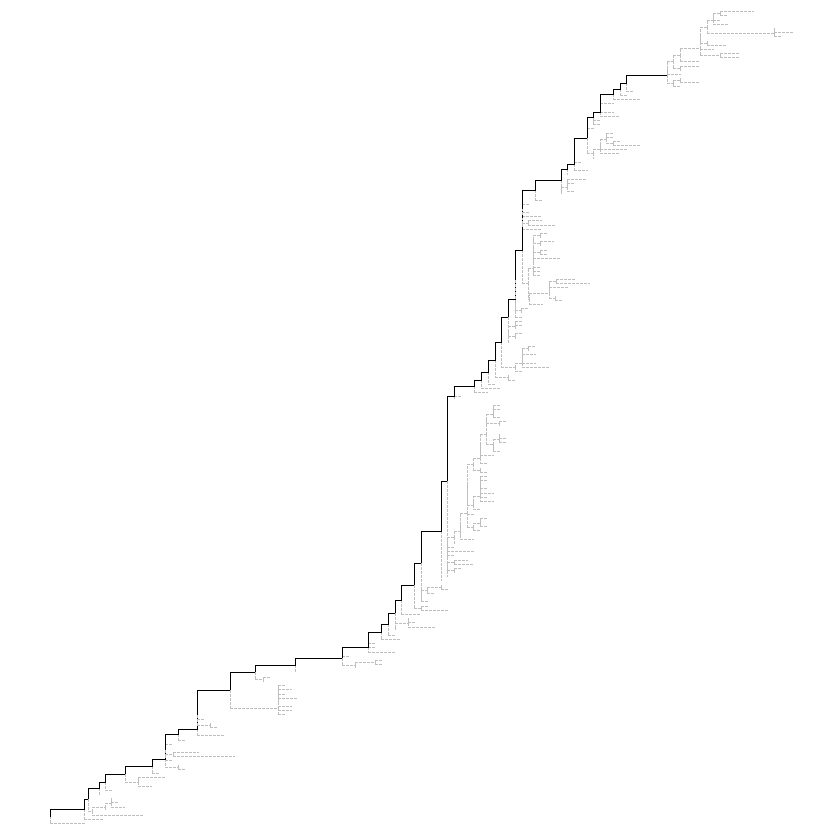

In [6]:
attr(tree, "group") <- rep(1, times = Ntip(tree) + tree$Nnode)
attr(tree, "group")[unique(unlist(paths))] <- 0
attr(tree, "group") <- factor(attr(tree, "group"))

ggtree(tree, aes(color=group, linetype=group)) + 
    scale_color_manual(values = c("black", "grey")) + 
    theme(legend.position = "none")

In [7]:
mutations <- fixationSites(paths)

In [8]:
snpTracing <- as.phylo(mutations)

d <- as_tibble(t(vapply(
    X = attr(snpTracing, "edgeSNPs"),
    FUN = function(snp) {
        if (length(snp) == 0) {
            res <- NA_character_
        } else {
            res <- character()
            snpNum <- length(snp)
            for (i in seq_len(snpNum)) {
                res <- paste0(res, snp[i])
                if (i < snpNum) {
                    if (i %% 4 == 0) {
                        res <- paste0(res, ",\n")
                    } else {
                        res <- paste0(res, ", ")
                    }
                }
            }

        }
        n <- attr(snp, "edge")[2]
        children <- sitePath:::.childrenTips(snpTracing, n)
        children <- getMRCA(tree, unlist(attr(snpTracing, "tipClusters")[children]))
        res <- c(res, children)
        names(res) <- c("SNPs", "node")
        return(res)
    },
    FUN.VALUE = c(character(1), integer(1))
)))

d[["node"]] <- as.integer(d[["node"]])
d <- na.omit(d)
d <- d[which(!duplicated(d[["node"]])), ]

x <- as_tibble(tree)
y <- full_join(x, d, by = "node")
tr <- as.treedata(y)

checkValidPhylo(tr@phylo)

Starting checking the validity of tr@phylo...
Found number of tips: n = 195 
Found number of nodes: m = 194 
Done.


In [9]:
pdf(file = file.path(PLOTS_DIR, "Smith2004_sites.pdf"))
for (site in clusterSites) {
    plotSingleSite(paths, site)
}
invisible(dev.off())

Warning message:
"Removed 378 rows containing missing values (geom_label_repel)."


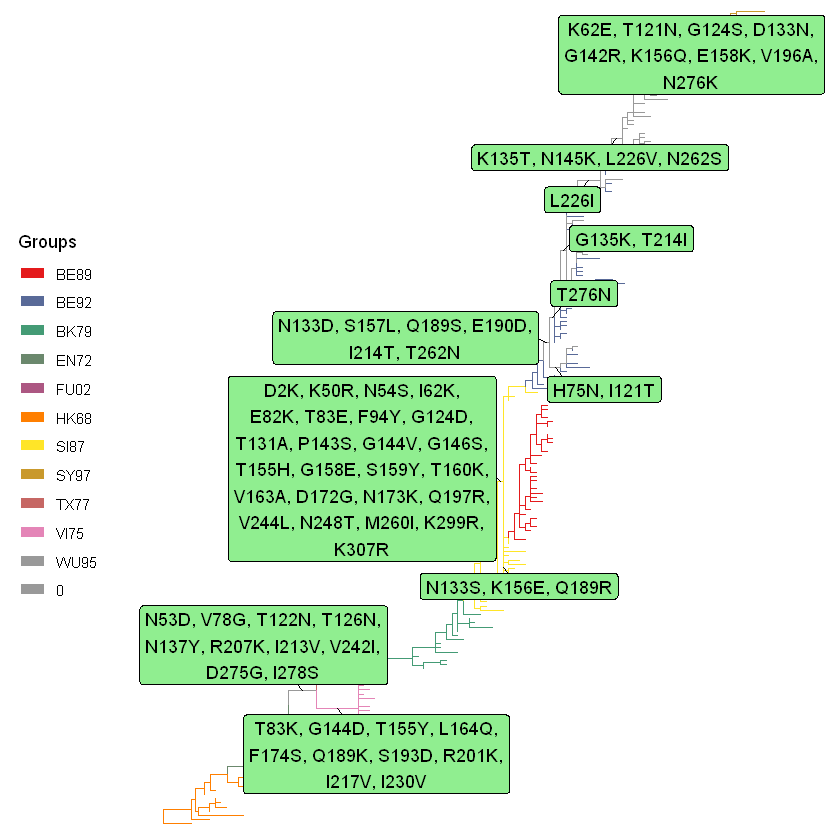

In [10]:
group <- split(clusterInfo[["id"]], clusterInfo[["cluster"]])

groupColors <- colorRampPalette(brewer.pal(9, "Set1"))(length(group))
names(groupColors) <- names(group)
groupColors["0"] <- "#999999"

p <- ggtree(groupOTU(tr, group, group_name = "color"), aes(color = color)) +
    scale_color_manual(values = as.list(groupColors), limits = names(groupColors)) +
    guides(
      color = guide_legend(
        override.aes = list(size = 3),
        title = 'Groups'
      )
    ) +
    theme(legend.position = "left")
ggsave(filename = file.path(PLOTS_DIR, "Smith2004_tree.pdf"), plot = p, width = 10, height = 8)

p <- p + geom_label_repel(
        aes(x=branch, label=SNPs),
        fill='lightgreen',
        color='black',
        min.segment.length = 0
    )
p

In [11]:
ggsave(filename = file.path(PLOTS_DIR, "Smith2004.pdf"), plot = p, width = 10, height = 8)

Warning message:
"Removed 378 rows containing missing values (geom_label_repel)."


In [12]:
x <- as_tibble(snpTracing)

d <- as_tibble(t(vapply(
    X = attr(snpTracing, "edgeSNPs"),
    FUN = function (snp) {
        if (length(snp) == 0) {
            res <- NA_character_
        } else {
            res <- character()
            snpNum <- length(snp)
            for (i in seq_len(snpNum)) {
                res <- paste0(res, snp[i])
                if (i < snpNum) {
                    if (i %% 4 == 0) {
                        res <- paste0(res, ",\n")
                    } else {
                        res <- paste0(res, ", ")
                    }
                }
            }

        }
        res <- c(res, attr(snp, "edge")[2])
        names(res) <- c("SNPs", "node")
        return(res)
    }, 
    FUN.VALUE = c(character(1), integer(1))
)))

d[["node"]] <- as.integer(d[["node"]])

y <- full_join(x, d, by = "node")
tree <- as.treedata(y)

Warning message:
"Removed 5 rows containing missing values (geom_label_repel)."


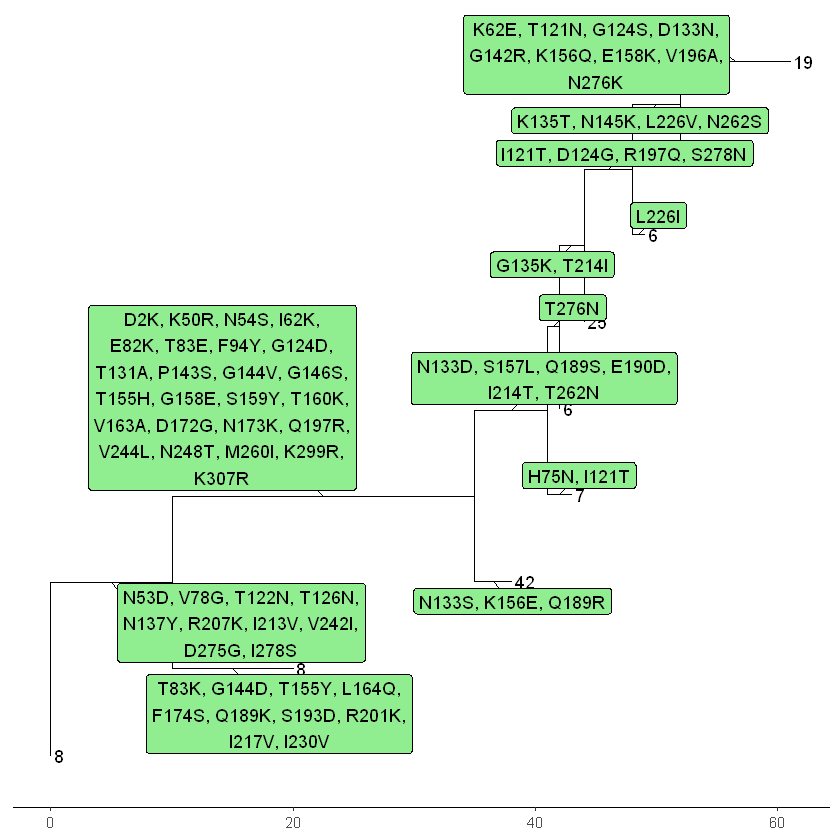

In [13]:
ggtree(tree) + geom_tiplab() +
    geom_label_repel(aes(x=branch, label=SNPs), fill='lightgreen', min.segment.length = 0) + theme_tree2()

### 2. ZIKV polyprotein

In [36]:
meta <- read.csv(
    file.path(METADATA_DIR, paste0(ZIKV_POLYPROTEIN_NAME, ".tsv")), 
    sep = "\t",
    row.names = "GenBank.Protein.Accession",
    na.strings = c("-N/A-", "Unknown"),
    stringsAsFactors = FALSE
)
rownames(meta) <- sapply(strsplit(rownames(meta), "\\."), "[", 1)
meta <- meta[, colSums(is.na(meta)) < nrow(meta)]

In [73]:
meta[which(meta[["Country"]] == "Taiwan"), ][["Country"]] <- "China"

In [74]:
treeDir <- file.path(TREES_DIR, ZIKV_POLYPROTEIN_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

In [75]:
paths <- lineagePath(tree, 0.05)

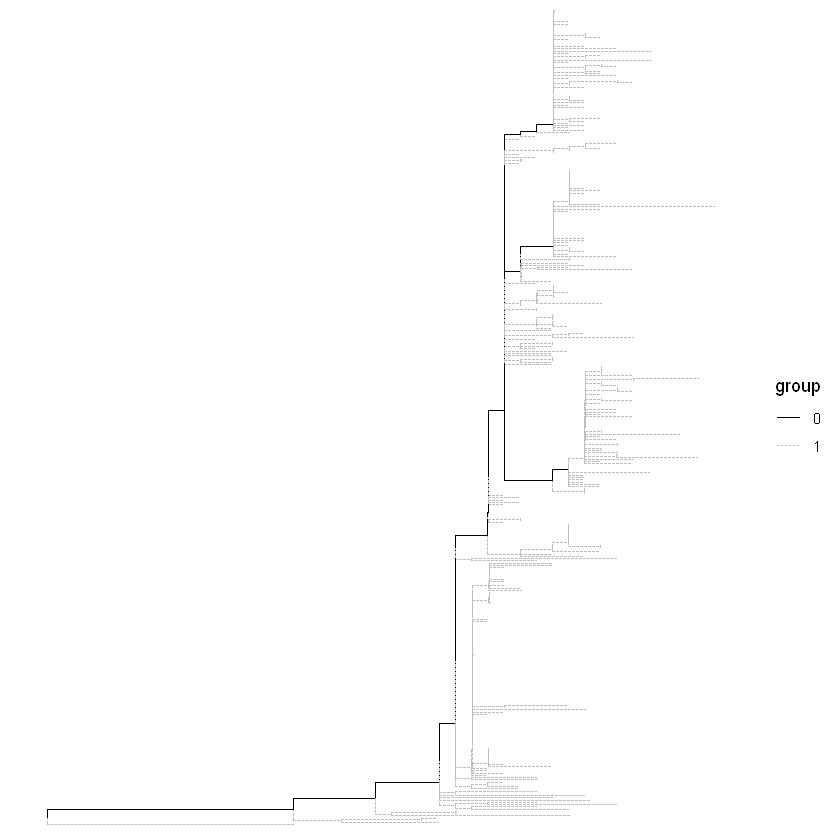

In [76]:
attr(tree, "group") <- rep(1, times = Ntip(tree) + tree$Nnode)
attr(tree, "group")[unique(unlist(paths))] <- 0
attr(tree, "group") <- factor(attr(tree, "group"))

ggtree(tree, aes(color=group, linetype=group)) + scale_color_manual(values = c("black", "grey"))

In [77]:
mutations <- fixationSites(paths)

In [78]:
snpTracing <- as.phylo(mutations)

In [79]:
snpTracing[["tip.label"]] <- LETTERS[seq_along(snpTracing[["tip.label"]])]

In [80]:
x <- as_tibble(snpTracing)

d <- as_tibble(t(vapply(
    X = attr(snpTracing, "edgeSNPs"),
    FUN = function (snp) {
        if (length(snp) == 0) {
            res <- NA_character_
        } else {
            res <- character()
            snpNum <- length(snp)
            for (i in seq_len(snpNum)) {
                res <- paste0(res, snp[i])
                if (i < snpNum) {
                    if (i %% 4 == 0) {
                        res <- paste0(res, ",\n")
                    } else {
                        res <- paste0(res, ", ")
                    }
                }
            }

        }
        res <- c(res, attr(snp, "edge")[2])
        names(res) <- c("SNPs", "node")
        return(res)
    }, 
    FUN.VALUE = c(character(1), integer(1))
)))

d[["node"]] <- as.integer(d[["node"]])

y <- full_join(x, d, by = "node")
tr <- as.treedata(y)

checkValidPhylo(tr@phylo)

Starting checking the validity of tr@phylo...
Found number of tips: n = 7 
Found number of nodes: m = 3 
Done.


In [81]:
# metaDir <- file.path(METADATA_DIR, ZIKV_POLYPROTEIN_NAME)

# dir.create(metaDir, showWarnings = FALSE)

# for (tips in attr(snpTracing, "tipClusters")) {
#     fileName <- as.character(length(tips))
#     write.csv(meta[tree$tip.label[tips], ], file.path(metaDir, paste0(fileName, ".csv")), na = "")
# }

In [82]:
countryData <- lapply(seq_along(snpTracing[["tip.label"]]), function(i) {
    tipName <- LETTERS[i]
    i <- attr(snpTracing, "tipClusters")[[i]]
    data.frame(
        "tip" = tipName,
        "Country" = meta[tree$tip.label[i], "Country"]
    )
})
countryData <- do.call(rbind, countryData)

In [83]:
df <- lapply(split(countryData, countryData[["Country"]]), function(i) {
    res <- reshape2::dcast(i, tip ~ Country, value.var = "Country", length)
    names(res)[2] <- "Num"
    res[["Country"]] <- unique(i[["Country"]])
    res
})
df <- do.call(rbind, df)

df <- df[order(df[["tip"]]), ]

df <- lapply(split(df, df[["tip"]]), function(i) {
    i[["Pos"]] <- cumsum(i[["Num"]]) - (0.5 * i[["Num"]])
    i
})
df <- do.call(rbind, df)
rownames(df) <- NULL

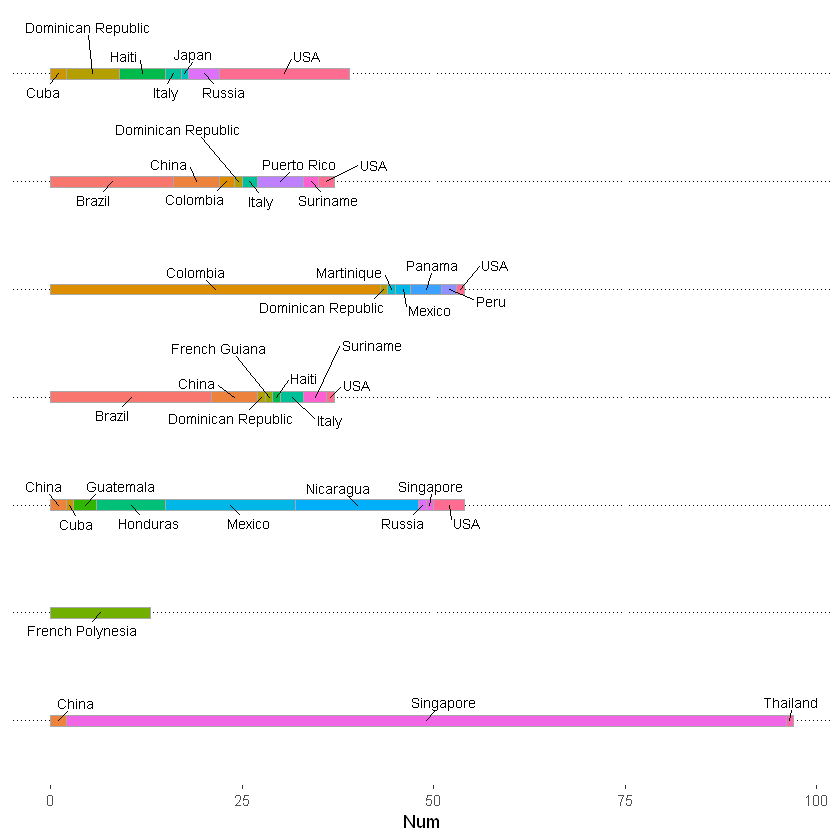

In [100]:
p1 <- ggplot(df, aes(x = Num, y = tip, fill = Country)) + 
    geom_bar(colour="#A9A9A9", stat="identity", position = position_stack(reverse = TRUE), width = 0.1) +
    geom_text_repel(aes(label=Country, x = Pos), size = 3, min.segment.length = 0, box.padding = 0.5) +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3),
        legend.position = "none"
    )
p1

Warning message:
"Removed 5 rows containing missing values (geom_label_repel)."


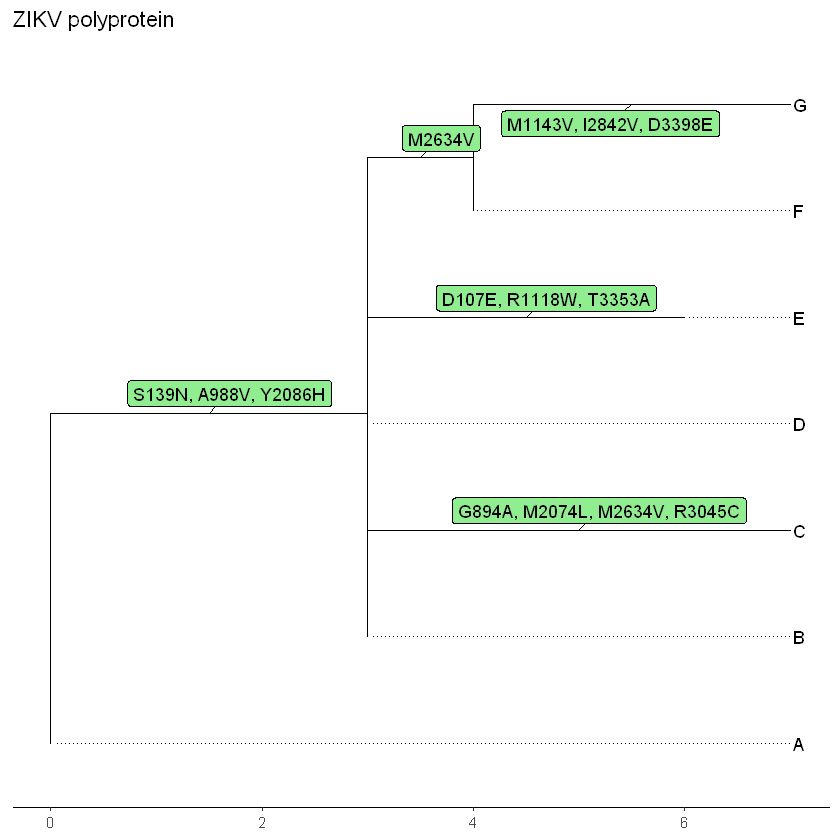

In [101]:
p <- ggtree(tr) + geom_tiplab(align = TRUE) +
    geom_label_repel(aes(x=branch, label=SNPs), fill='lightgreen', min.segment.length = 0) +
    theme_tree2() +
    ggtitle("ZIKV polyprotein")
p

Warning message:
"Removed 5 rows containing missing values (geom_label_repel)."


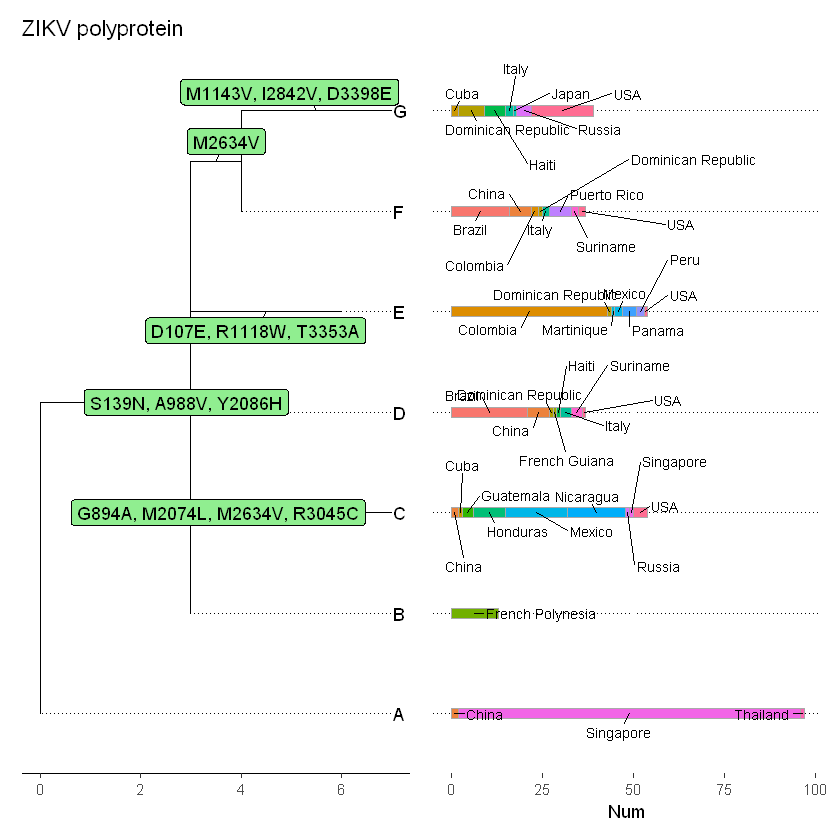

In [102]:
p <- p1 %>% insert_left(p)
p

In [103]:
ggsave(filename = file.path(PLOTS_DIR, paste0(ZIKV_POLYPROTEIN_NAME, ".pdf")), plot = p, width = 14)

Saving 14 x 6.67 in image

Warning message:
"Removed 5 rows containing missing values (geom_label_repel)."


### 3. SARS-CoV-2 CDS

In [104]:
meta <- read.csv(
    file.path(METADATA_DIR, paste0(SARS_COV_2_CDS_NAME, ".csv")), 
    row.names = "Accession.ID",
    stringsAsFactors = FALSE
)

In [105]:
treeDir <- file.path(TREES_DIR, SARS_COV_2_CDS_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.GTRGAMMA"))
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

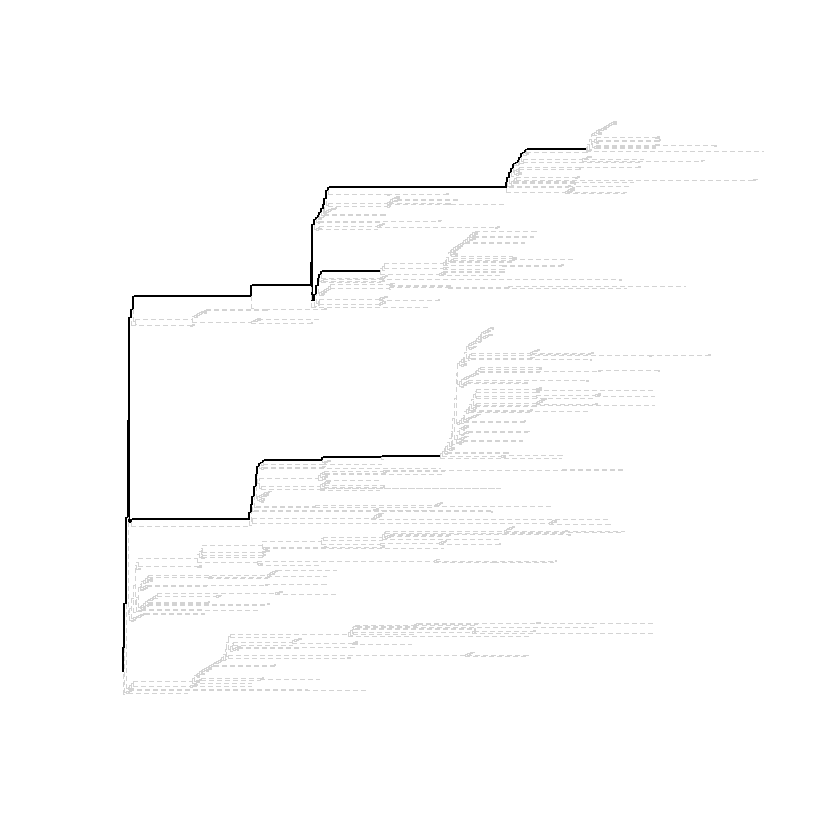

In [106]:
paths <- lineagePath(tree, similarity = 0.03)
plot(paths)

In [107]:
mutations <- fixationSites(paths)

In [108]:
snpTracing <- as.phylo(mutations)

x <- as_tibble(snpTracing)

d <- as_tibble(t(vapply(
    X = attr(snpTracing, "edgeSNPs"),
    FUN = function (snp) {
        if (length(snp) == 0) {
            res <- NA_character_
        } else {
            res <- character()
            snpNum <- length(snp)
            for (i in seq_len(snpNum)) {
                res <- paste0(res, snp[i])
                if (i < snpNum) {
                    if (i %% 4 == 0) {
                        res <- paste0(res, ",\n")
                    } else {
                        res <- paste0(res, ", ")
                    }
                }
            }

        }
        res <- c(res, attr(snp, "edge")[2])
        names(res) <- c("SNPs", "node")
        return(res)
    }, 
    FUN.VALUE = c(character(1), integer(1))
)))

d[["node"]] <- as.integer(d[["node"]])

y <- full_join(x, d, by = "node")
tr <- as.treedata(y)

checkValidPhylo(tr@phylo)

Starting checking the validity of tr@phylo...
Found number of tips: n = 6 
Found number of nodes: m = 3 
Done.


Warning message:
"Removed 4 rows containing missing values (geom_label_repel)."


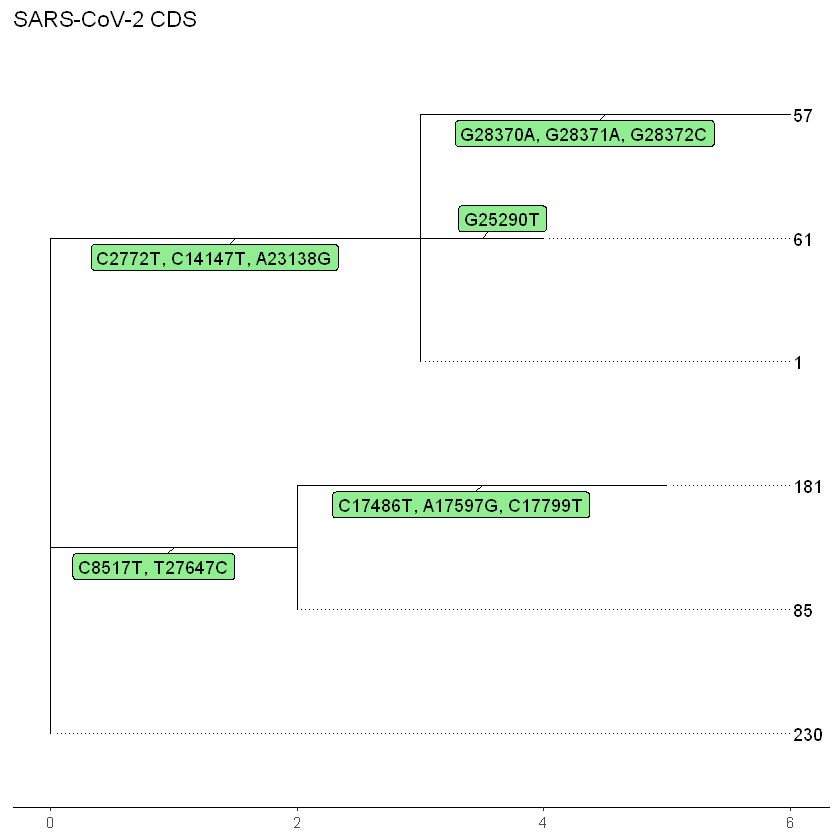

In [109]:
p <- ggtree(tr) + geom_tiplab(align = TRUE) +
    geom_label_repel(aes(x=branch, label=SNPs), fill='lightgreen', min.segment.length = 0) + 
    theme_tree2() +
    ggtitle("SARS-CoV-2 CDS")
p

In [110]:
countryData <- lapply(attr(snpTracing, "tipClusters"), function(i) {
    data.frame(
        "tip" = as.character(length(i)),
        "Country" = meta[tree$tip.label[i], "Country"]
    )
})
countryData <- do.call(rbind, countryData)

In [111]:
df <- lapply(split(countryData, countryData[["Country"]]), function(i) {
    res <- reshape2::dcast(i, tip ~ Country, value.var = "Country", length)
    names(res)[2] <- "Num"
    res[["Country"]] <- unique(i[["Country"]])
    res
})
df <- do.call(rbind, df)

df <- df[order(df[["tip"]]), ]

df <- lapply(split(df, df[["tip"]]), function(i) {
    i[["Pos"]] <- cumsum(i[["Num"]]) - (0.5 * i[["Num"]])
    i
})
df <- do.call(rbind, df)
rownames(df) <- NULL

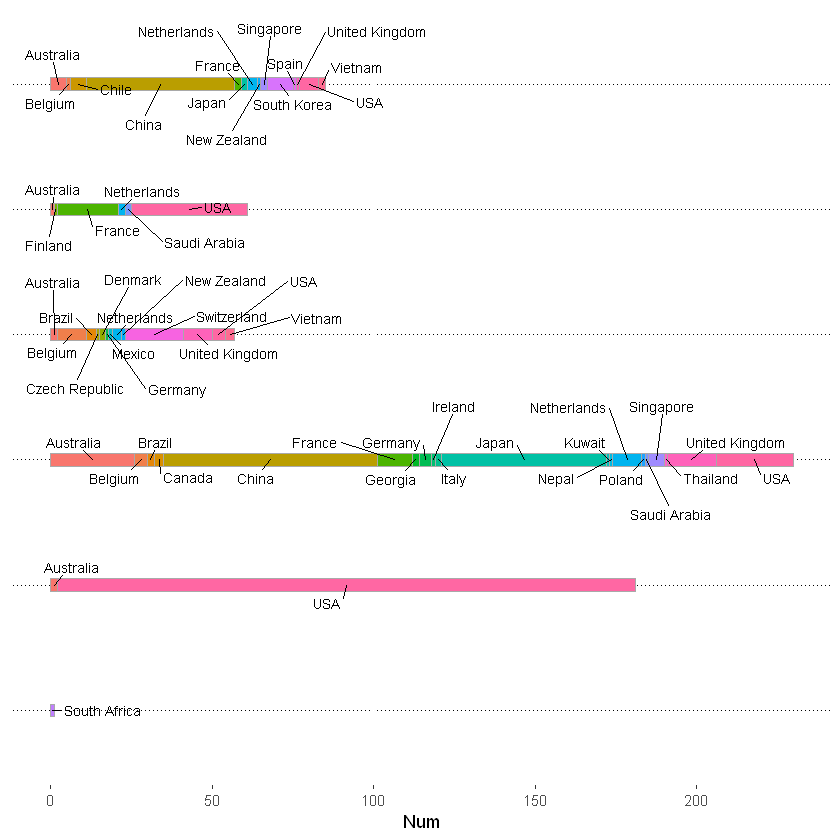

In [112]:
p1 <- ggplot(df, aes(x = Num, y = tip, fill = Country)) + 
    geom_bar(colour="#A9A9A9", stat="identity", position = position_stack(reverse = TRUE), width = 0.1) +
    geom_text_repel(aes(label=Country, x = Pos), size = 3, min.segment.length = 0, box.padding = 0.5) +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3),
        legend.position = "none"
    )
p1

Warning message:
"Removed 4 rows containing missing values (geom_label_repel)."


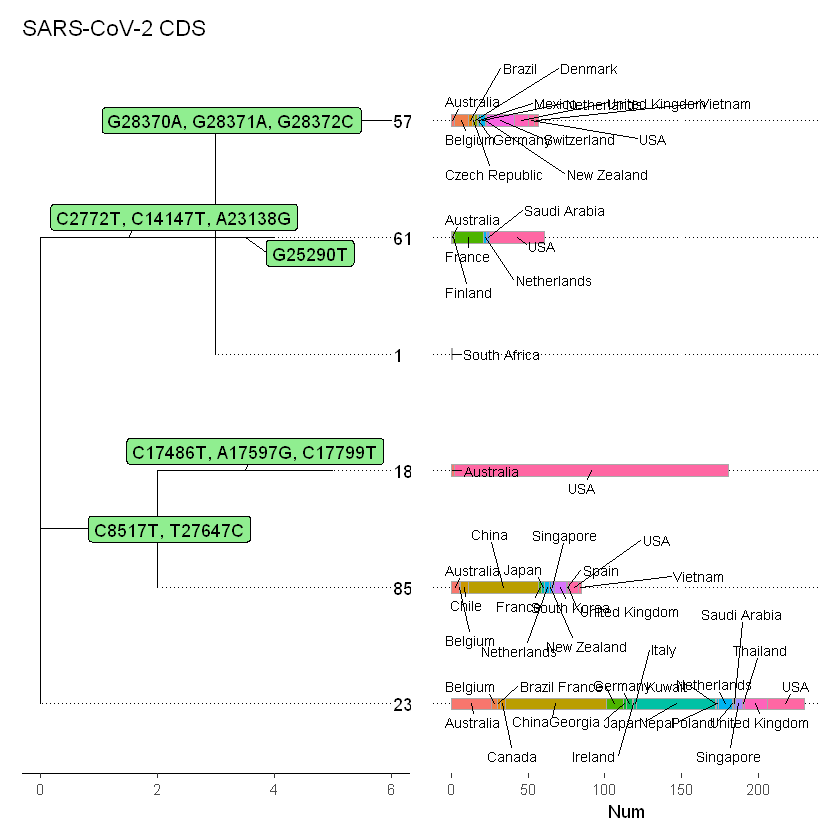

In [113]:
p <- p1 %>% insert_left(p)
p

In [114]:
ggsave(filename = file.path(PLOTS_DIR, paste0(SARS_COV_2_CDS_NAME, ".pdf")), plot = p, width = 14)

Saving 14 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_label_repel)."


### 1. H1N1 HA

In [34]:
meta <- read.csv(
    file.path(METADATA_DIR, paste0(H1N1_HA_NAME, ".tsv")), 
    sep = "\t", 
    na.strings = c("-N/A-", "Unknown"),
    row.names = "Sequence.Accession"
)

In [35]:
treeDir <- file.path(TREES_DIR, H1N1_HA_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- drop.tip(tree, "MK615591")
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

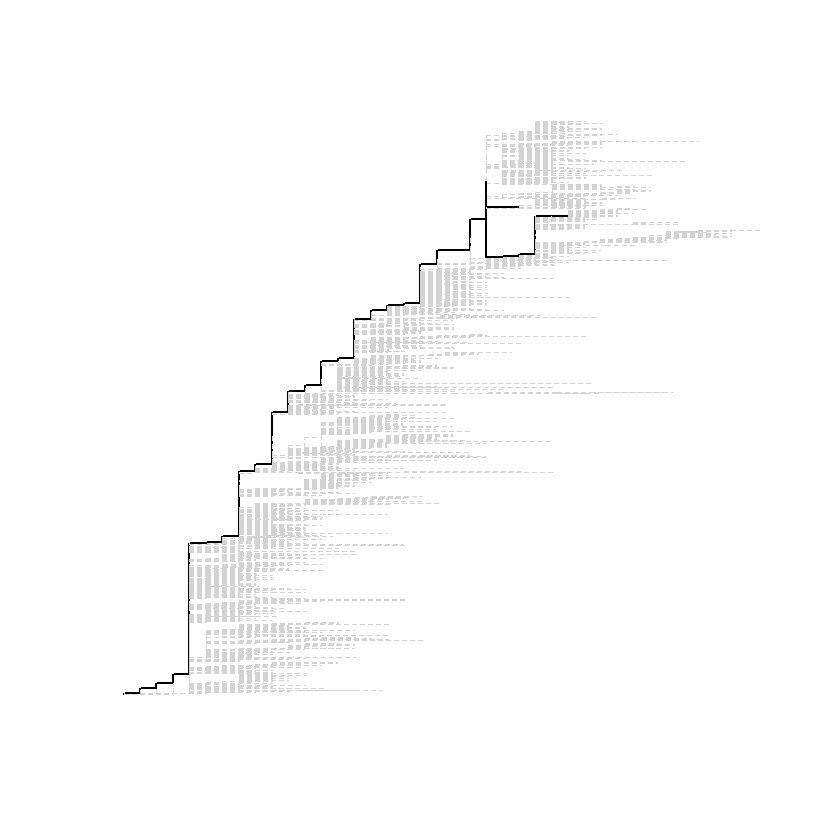

In [36]:
paths <- lineagePath(tree, 0.01)
plot(paths)

In [37]:
mutations <- fixationSites(paths)

In [38]:
snpTracing <- as.phylo(mutations)

x <- as_tibble(snpTracing)

d <- as_tibble(t(vapply(
    X = attr(snpTracing, "edgeSNPs"),
    FUN = function (snp) {
        if (length(snp) == 0) {
            res <- NA_character_
        } else {
            res <- character()
            snpNum <- length(snp)
            for (i in seq_len(snpNum)) {
                res <- paste0(res, snp[i])
                if (i < snpNum) {
                    if (i %% 4 == 0) {
                        res <- paste0(res, ",\n")
                    } else {
                        res <- paste0(res, ", ")
                    }
                }
            }

        }
        res <- c(res, attr(snp, "edge")[2])
        names(res) <- c("SNPs", "node")
        return(res)
    }, 
    FUN.VALUE = c(character(1), integer(1))
)))

d[["node"]] <- as.integer(d[["node"]])

y <- full_join(x, d, by = "node")
tr <- as.treedata(y)

checkValidPhylo(tr@phylo)

Starting checking the validity of tr@phylo...
Found number of tips: n = 8 
Found number of nodes: m = 6 
Done.


In [39]:
# metaDir <- file.path(METADATA_DIR, H1N1_HA_NAME)

# dir.create(metaDir, showWarnings = FALSE)

# for (tips in attr(snpTracing, "tipClusters")) {
#     fileName <- as.character(length(tips))
#     write.csv(meta[tree$tip.label[tips], ], file.path(metaDir, paste0(fileName, ".csv")), na = "")
# }

In [40]:
simMatrix <- similarityMatrix(tree)

In [41]:
pca <- prcomp(simMatrix)

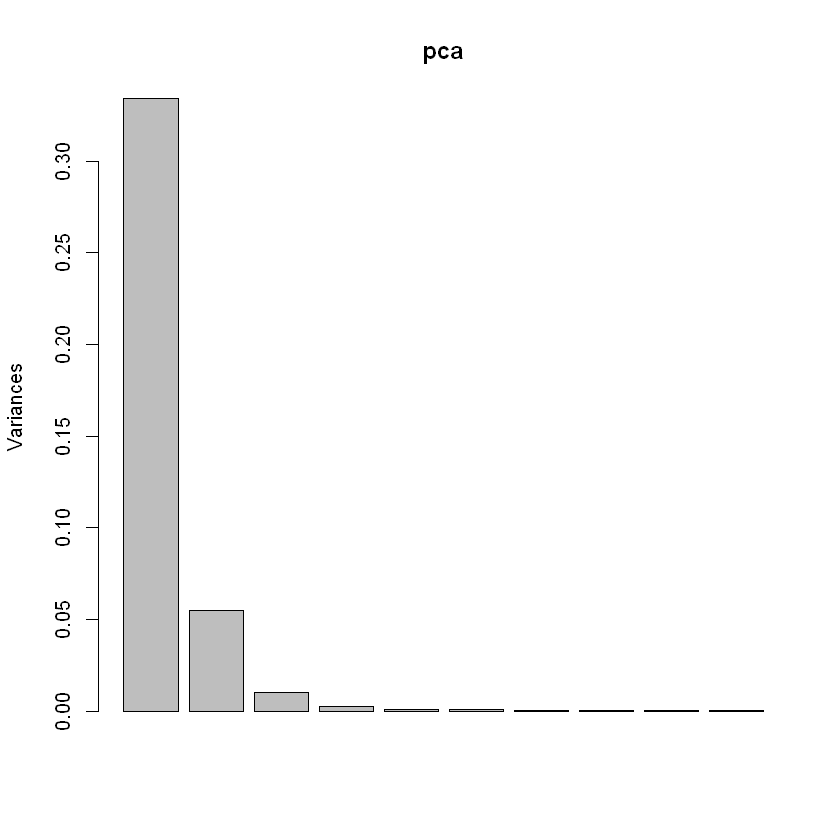

In [42]:
plot(pca)

In [44]:
x <- lapply(attr(snpTracing, "tipClusters"), function(tips) {
    pc1 <- pca[["rotation"]][, "PC1", drop = FALSE][tree[["tip.label"]][tips], , drop = FALSE]
    data.frame("PC1" = pc1, "tipNum" = as.character(length(tips)))
})
x <- do.call(rbind, x)

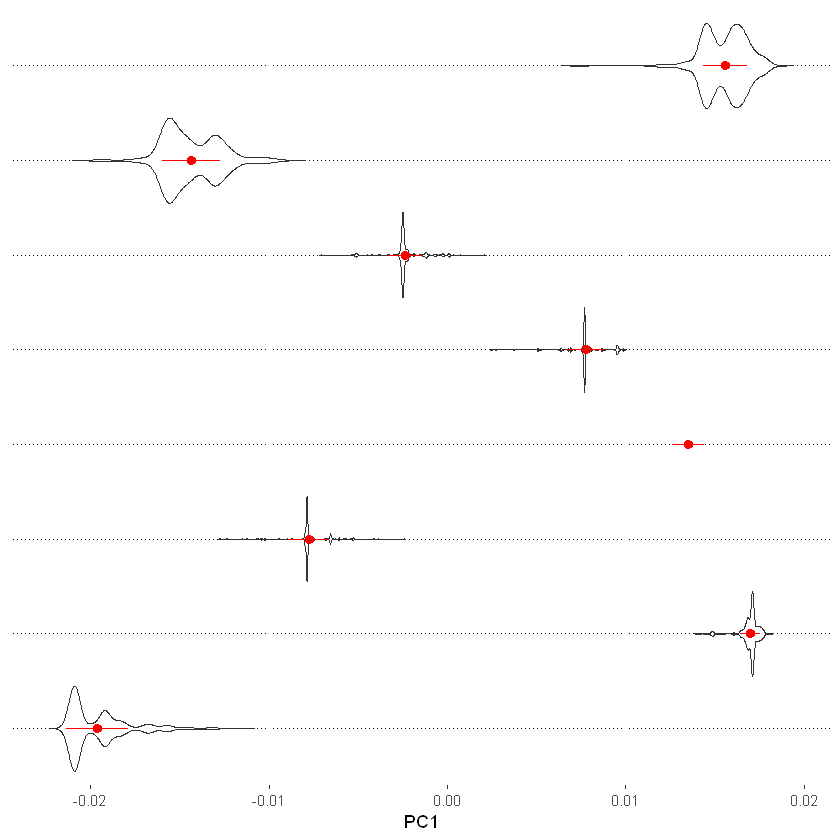

In [45]:
p1 <- ggplot(x, aes(PC1, tipNum)) +
    geom_violin(trim = FALSE, scale = "width") +
    stat_summary(fun.data = function(x) {
       m <- mean(x)
       ymin <- m-sd(x)
       ymax <- m+sd(x)
       return(c(y=m,ymin=ymin,ymax=ymax))
    }, color = "red") +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3)
    )
p1

Warning message:
"Removed 7 rows containing missing values (geom_label_repel)."


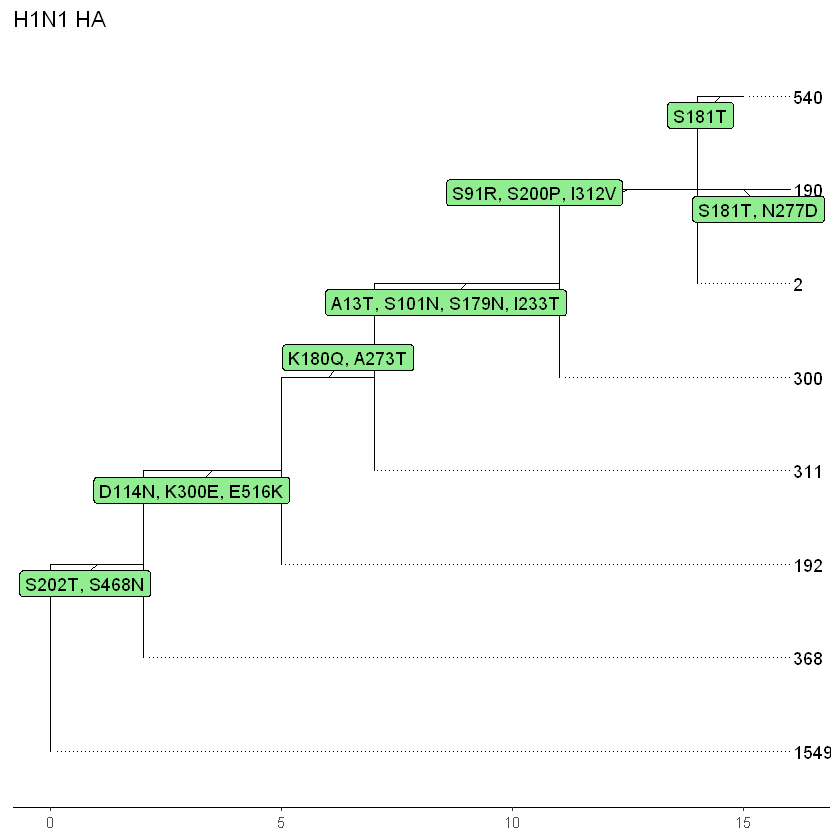

In [43]:
p <- ggtree(tr) + geom_tiplab(align = TRUE) +
    geom_label_repel(aes(x=branch, label=SNPs), fill='lightgreen', min.segment.length = 0) + 
    theme_tree2() +
    ggtitle("H1N1 HA")
p

Warning message:
"Removed 7 rows containing missing values (geom_label_repel)."


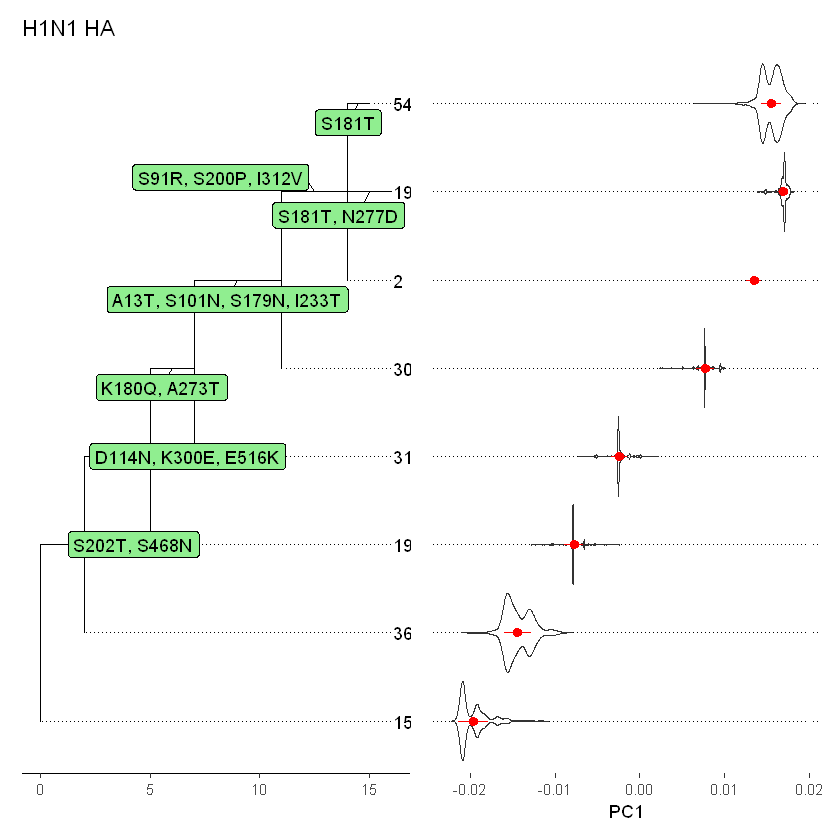

In [46]:
p <- p1 %>% insert_left(p)
p

In [47]:
ggsave(filename = file.path(PLOTS_DIR, paste0(H1N1_HA_NAME, ".pdf")), plot = p, width = 14)

Saving 14 x 6.67 in image

Warning message:
"Removed 7 rows containing missing values (geom_label_repel)."


### 2. H3N2

In [115]:
meta <- read.csv(
    file.path(METADATA_DIR, paste0(H3N2_HA_NAME, ".tsv")), 
    sep = "\t", 
    na.strings = c("-N/A-", "Unknown")
)
meta <- unique(meta)
rownames(meta) <- meta[["Sequence.Accession"]]
meta <- meta[, -2]

In [116]:
treeDir <- file.path(TREES_DIR, H3N2_HA_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- drop.tip(tree, "AB284320")
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

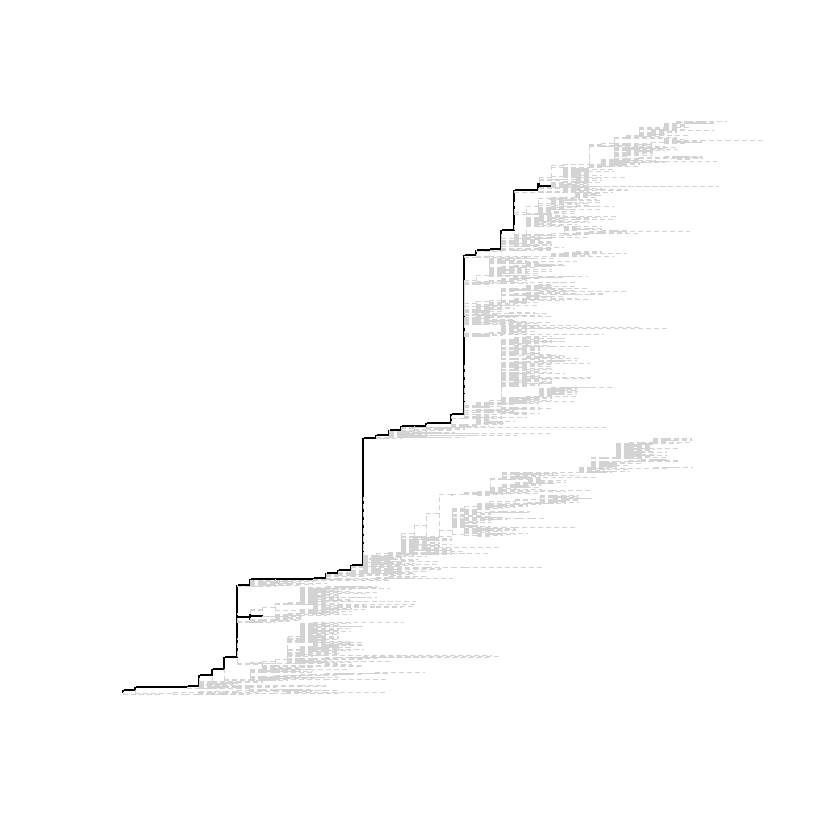

In [117]:
paths <- lineagePath(tree, 0.01)
plot(paths)

In [118]:
mutations <- fixationSites(paths)

In [119]:
snpTracing <- as.phylo(mutations)

x <- as_tibble(snpTracing)

d <- as_tibble(t(vapply(
    X = attr(snpTracing, "edgeSNPs"),
    FUN = function (snp) {
        if (length(snp) == 0) {
            res <- NA_character_
        } else {
            res <- character()
            snpNum <- length(snp)
            for (i in seq_len(snpNum)) {
                res <- paste0(res, snp[i])
                if (i < snpNum) {
                    if (i %% 4 == 0) {
                        res <- paste0(res, ",\n")
                    } else {
                        res <- paste0(res, ", ")
                    }
                }
            }

        }
        res <- c(res, attr(snp, "edge")[2])
        names(res) <- c("SNPs", "node")
        return(res)
    }, 
    FUN.VALUE = c(character(1), integer(1))
)))

d[["node"]] <- as.integer(d[["node"]])

y <- full_join(x, d, by = "node")
tr <- as.treedata(y)

checkValidPhylo(tr@phylo)

Starting checking the validity of tr@phylo...
Found number of tips: n = 8 
Found number of nodes: m = 6 
Done.


In [120]:
# metaDir <- file.path(METADATA_DIR, H3N2_HA_NAME)

# dir.create(metaDir, showWarnings = FALSE)

# for (tips in attr(snpTracing, "tipClusters")) {
#     fileName <- as.character(length(tips))
#     write.csv(meta[tree$tip.label[tips], ], file.path(metaDir, paste0(fileName, ".csv")), na = "")
# }

In [121]:
simMatrix <- similarityMatrix(tree)

In [122]:
x <- lapply(attr(snpTracing, "tipClusters"), function(tips) {
    pc1 <- simMatrix[, 1, drop = FALSE][tree[["tip.label"]][tips], ]
    data.frame("PC1" = pc1, "tipNum" = as.character(length(tips)))
})
x <- do.call(rbind, x)

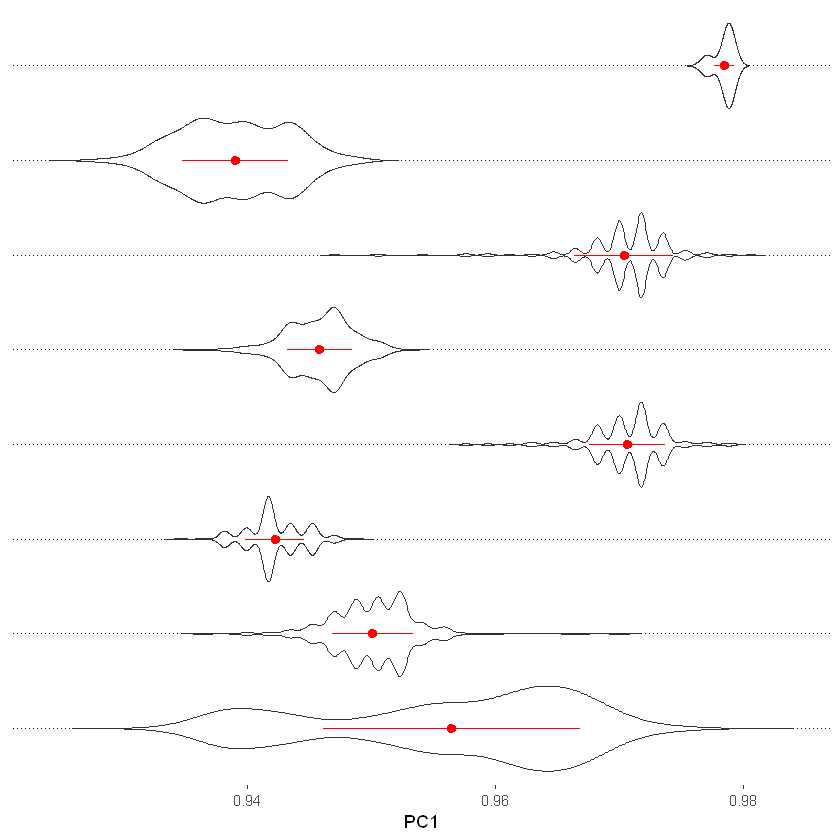

In [123]:
p1 <- ggplot(x, aes(PC1, tipNum)) +
    geom_violin(trim = FALSE, scale = "width") +
    stat_summary(fun.data = function(x) {
       m <- mean(x)
       ymin <- m-sd(x)
       ymax <- m+sd(x)
       return(c(y=m,ymin=ymin,ymax=ymax))
    }, color = "red") +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3)
    )
p1

Warning message:
"Removed 7 rows containing missing values (geom_label_repel)."


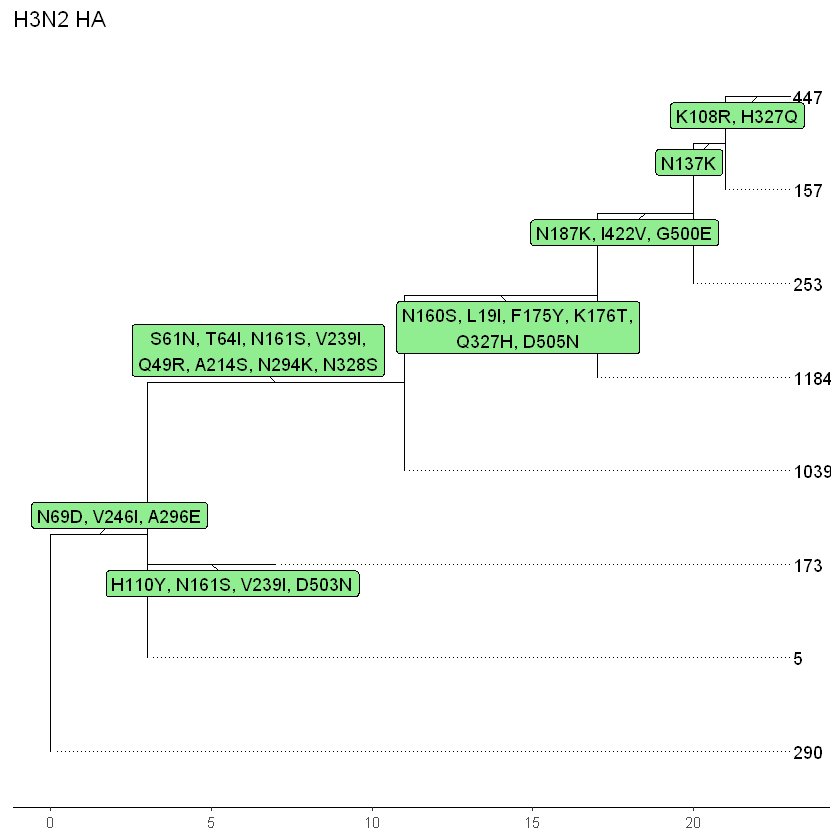

In [124]:
p <- ggtree(tr) + geom_tiplab(align = TRUE) +
    geom_label_repel(aes(x=branch, label=SNPs), fill='lightgreen', min.segment.length = 0) + 
    theme_tree2() +
    ggtitle("H3N2 HA")
p

Warning message:
"Removed 7 rows containing missing values (geom_label_repel)."


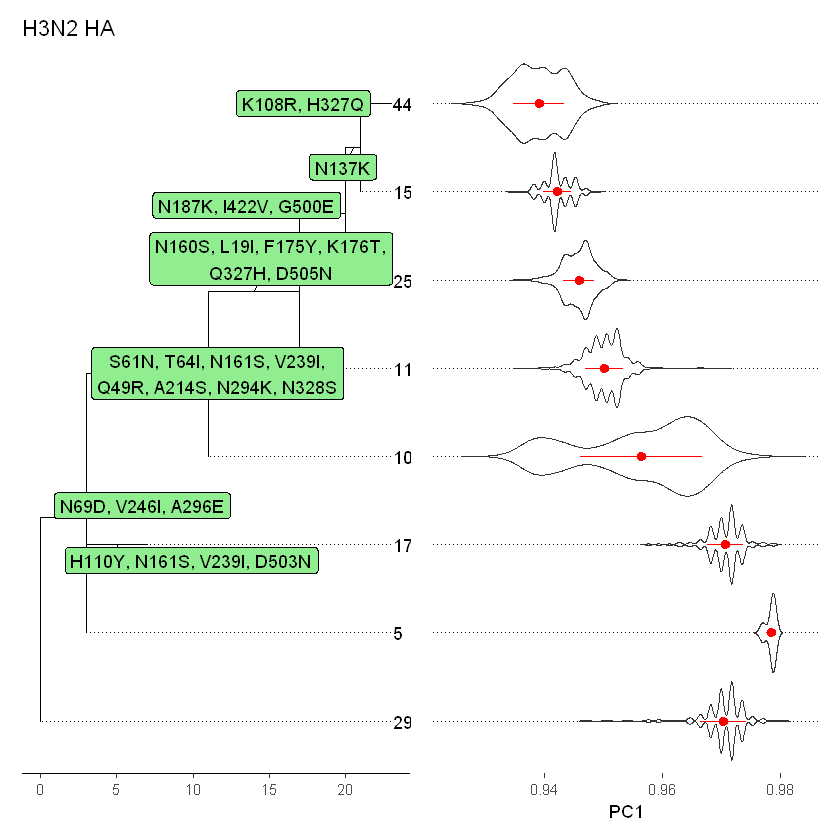

In [125]:
p <- p1 %>% insert_left(p)
p

In [126]:
ggsave(filename = file.path(PLOTS_DIR, paste0(H3N2_HA_NAME, "_sim.pdf")), plot = p, width = 14)

Saving 14 x 6.67 in image

Warning message:
"Removed 7 rows containing missing values (geom_label_repel)."


In [127]:
pca <- prcomp(simMatrix)

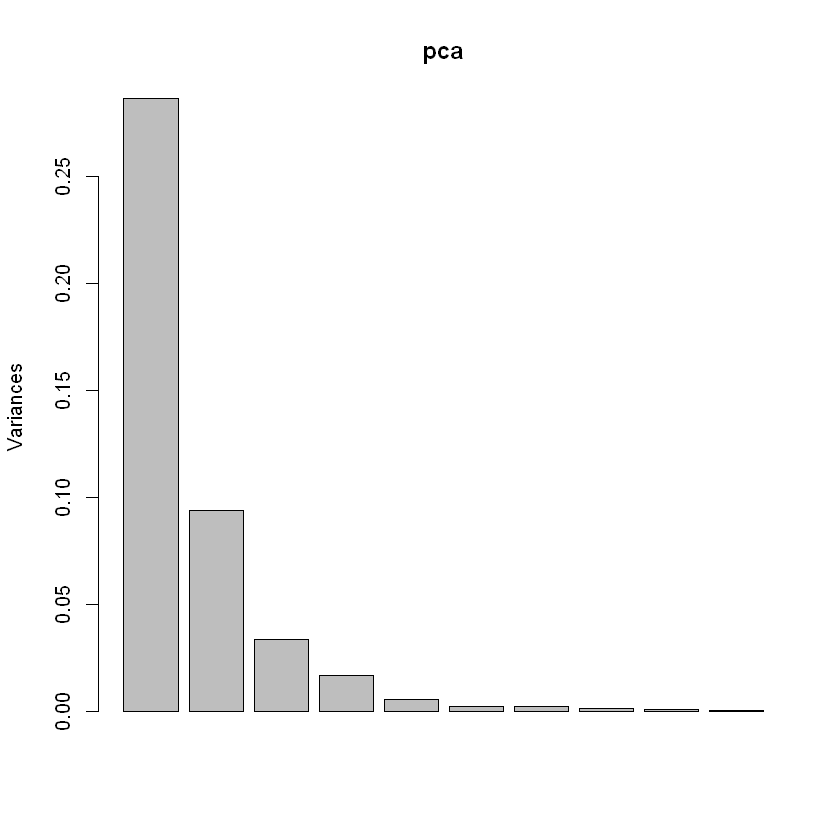

In [128]:
plot(pca)

In [129]:
x <- lapply(attr(snpTracing, "tipClusters"), function(tips) {
    pc1 <- pca[["rotation"]][, "PC1", drop = FALSE][tree[["tip.label"]][tips], , drop = FALSE]
    data.frame("PC1" = pc1, "tipNum" = as.character(length(tips)))
})
x <- do.call(rbind, x)

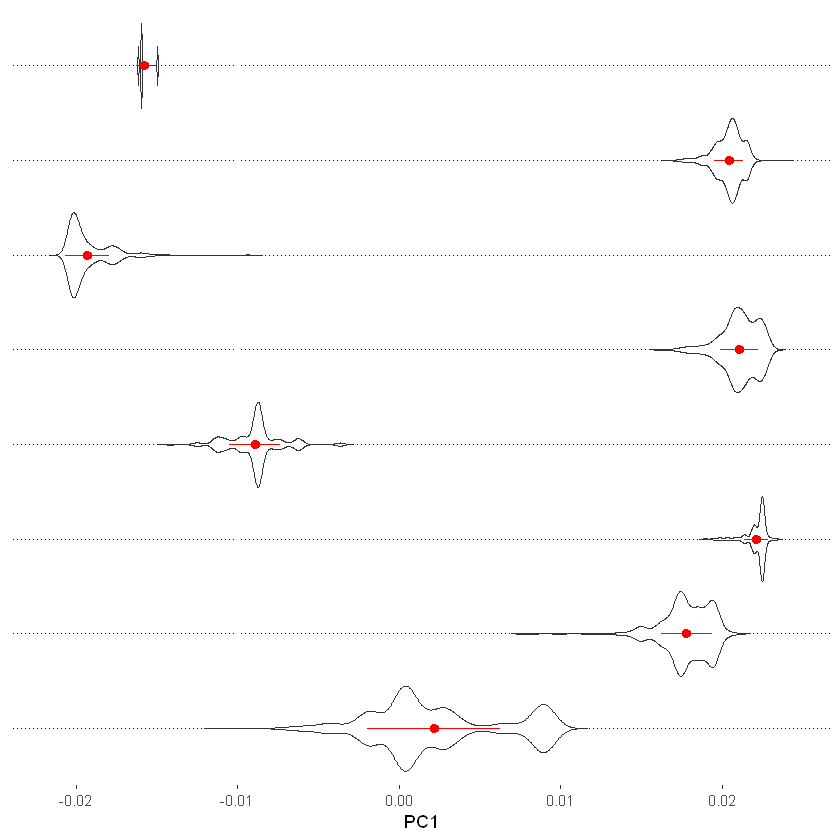

In [130]:
p1 <- ggplot(x, aes(PC1, tipNum)) +
    geom_violin(trim = FALSE, scale = "width") +
    stat_summary(fun.data = function(x) {
       m <- mean(x)
       ymin <- m-sd(x)
       ymax <- m+sd(x)
       return(c(y=m,ymin=ymin,ymax=ymax))
    }, color = "red") +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3)
    )
p1

Warning message:
"Removed 7 rows containing missing values (geom_label_repel)."


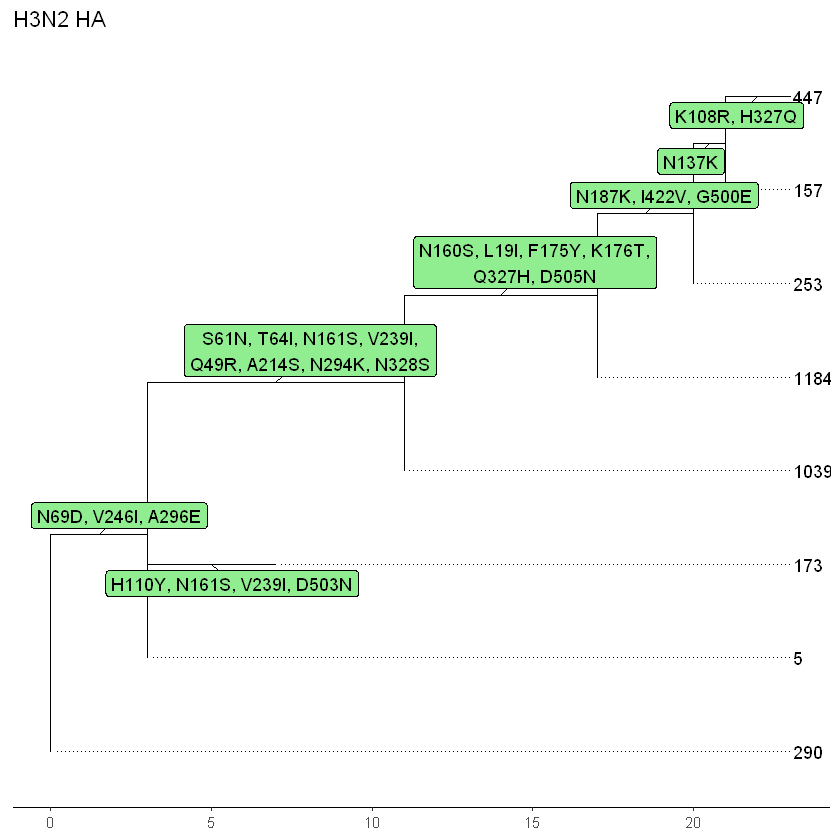

In [131]:
p <- ggtree(tr) + geom_tiplab(align = TRUE) +
    geom_label_repel(aes(x=branch, label=SNPs), fill='lightgreen', min.segment.length = 0) + 
    theme_tree2() +
    ggtitle("H3N2 HA")
p

Warning message:
"Removed 7 rows containing missing values (geom_label_repel)."


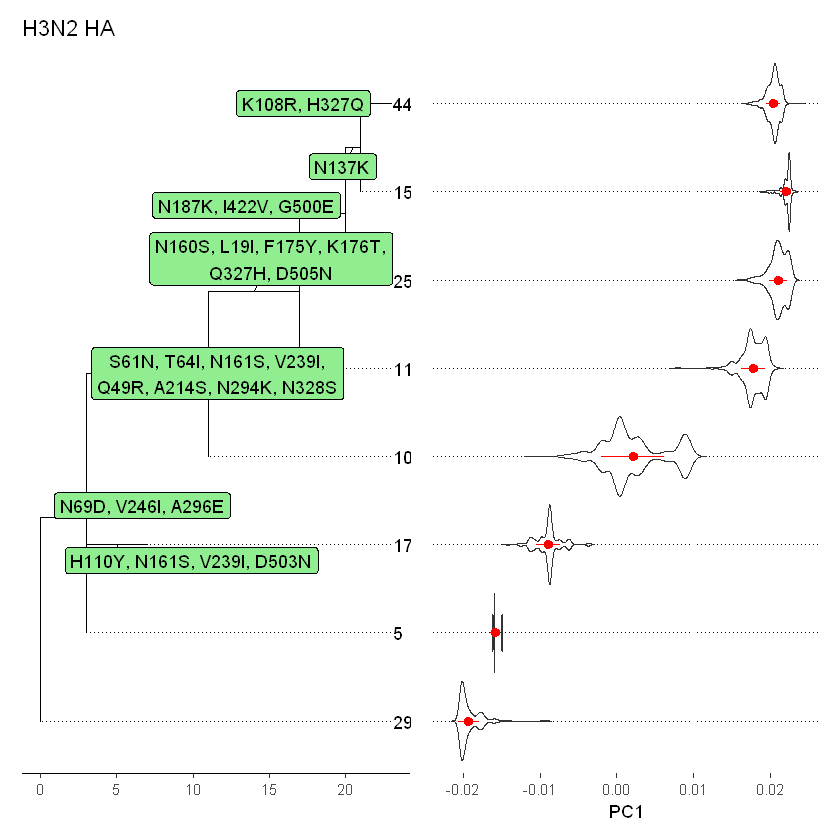

In [132]:
p <- p1 %>% insert_left(p)
p

In [133]:
ggsave(filename = file.path(PLOTS_DIR, paste0(H3N2_HA_NAME, ".pdf")), plot = p, width = 14)

Saving 14 x 6.67 in image

Warning message:
"Removed 7 rows containing missing values (geom_label_repel)."
